# Week 12: Part 2 - PCA 

**DATA110**
*Brian Roepke*

This is an extension of the project using the wine dataset.

1. use PCA for dimensionality reduction. Try different component values to find the minimum principal components that explains most of the variability. Plot a scatterplot for each iteration.

2. Create any 3 multi-class models. See: https://scikit-learn.org/stable/modules/multiclass.html

3. Create a pipeline that includes the classifier and StandardScaler. For the PCA models, also include PCA.

4. Compare the results of each classifier with and without PCA. Compare models using Kfold cross validation with 10 folds. This means you will have 6 models (3 without PCA and 3 without PCA)

References:

https://scikit-learn.org/stable/modules/cross_validation.html

In [1]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings('ignore')

# Validation Metrics
from sklearn import metrics

# Pipeline and preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression #(setting multi_class=”multinomial”)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("wine.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Class                 178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Ash Alcalinity        178 non-null    float64
 5   Magnesium             178 non-null    int64  
 6   Total phenols         178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid phenols  178 non-null    float64
 9   Proanthocyanins       178 non-null    float64
 10  Color intensity       178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD280/OD315           178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [4]:
df.shape

(178, 14)

### Data Setup

 - create a `labels` variable from the `Class`
 - drop the `Class` from the dataset and create a new variable called `data` with that.
 - Use the `MinMaxScaler` from sklearn to normalize the data.


In [9]:
y = df['Class'].copy()
X = df.drop(columns=['Class']).copy().values

In [10]:
print(X.shape)
print(y.shape)

(178, 13)
(178,)


In [11]:
def get_variance(X, n):
    scaler = StandardScaler()
    pca = PCA(n_components=n)

    pca.fit(scaler.fit_transform(X))
    
    return pca.explained_variance_ratio_.cumsum()[-1:]

In [12]:
for i in range(1,14):
    print('Components:\t', i, '=\t',get_variance(X, i), '\tCumulative Variance')

Components:	 1 =	 [0.36198848] 	Cumulative Variance
Components:	 2 =	 [0.55406338] 	Cumulative Variance
Components:	 3 =	 [0.66529969] 	Cumulative Variance
Components:	 4 =	 [0.73598999] 	Cumulative Variance
Components:	 5 =	 [0.80162293] 	Cumulative Variance
Components:	 6 =	 [0.85098116] 	Cumulative Variance
Components:	 7 =	 [0.89336795] 	Cumulative Variance
Components:	 8 =	 [0.92017544] 	Cumulative Variance
Components:	 9 =	 [0.94239698] 	Cumulative Variance
Components:	 10 =	 [0.96169717] 	Cumulative Variance
Components:	 11 =	 [0.97906553] 	Cumulative Variance
Components:	 12 =	 [0.99204785] 	Cumulative Variance
Components:	 13 =	 [1.] 	Cumulative Variance


## Plot the Threshold for Explained Variance

https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

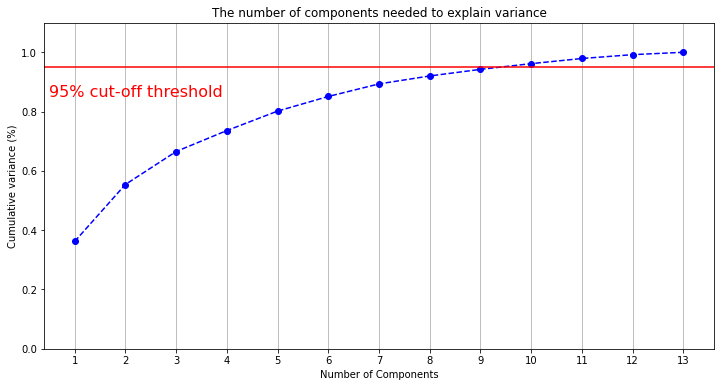

In [31]:
scaler = StandardScaler()
data_rescaled = scaler.fit_transform(X)

pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 14, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 14, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

## Plotting Each Component vs. Original Data

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [74]:
def plot_pca(X, n):
    f, ax = plt.subplots(figsize=(4,4))
    pca = PCA(n_components=n)
    pca.fit(X)
    X_new = pca.inverse_transform(pca.transform(X))
    
    ax.scatter(X[:, 0], X[:, 1], alpha=0.2)
    ax.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
    ax.axis('equal')
    ax.set_title(f'Number of Components: {n}')
    
    return ax

In [80]:
def transform_pca(X, n):
    
    pca = PCA(n_components=n)
    pca.fit(X)
    X_new = pca.inverse_transform(pca.transform(X))
    
    return X_new

In [82]:
fig, axes = plt.subplots(3, 2, figsize=(6,6))

transform_pca(X, 1)
ax.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
ax = sns.scatterplot(X[:, 0], X[:, 1], ax=axes[0, 0], palette='tab20')
ax = sns.scatterplot(x="y", y="balance", data=df, ax=axes[0, 1], palette='tab20')

SyntaxError: invalid syntax (<ipython-input-82-ec36f9ca9446>, line 4)

In [ ]:
ax[0, 0] = plot_pca(X, 1)
ax[0, 1] = plot_pca(X, 2)
ax[1, 0] = plot_pca(X, 2)
ax[1, 1] = plot_pca(X, 2)
plt.show()

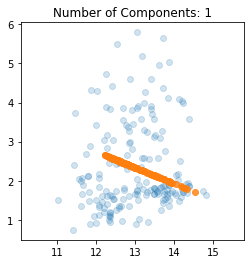

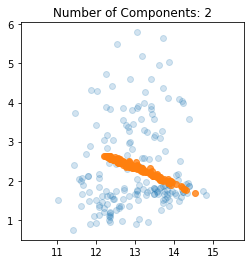

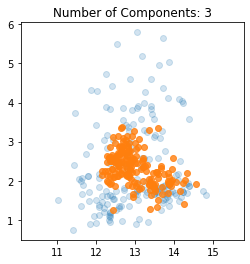

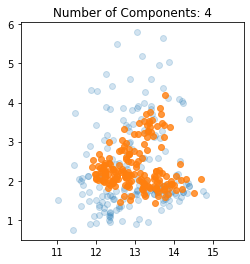

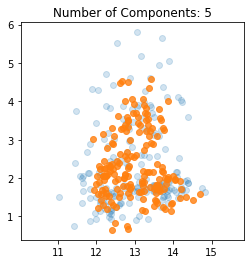

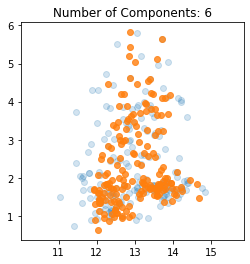

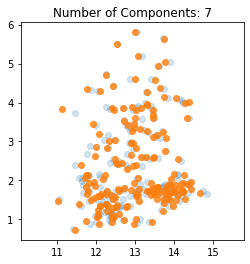

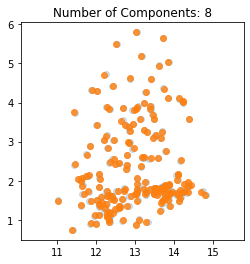

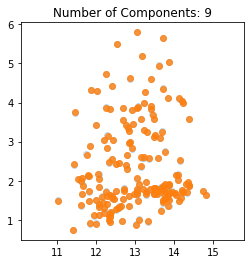

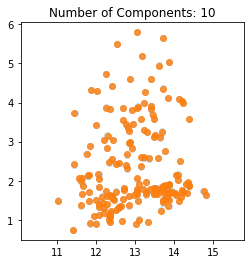

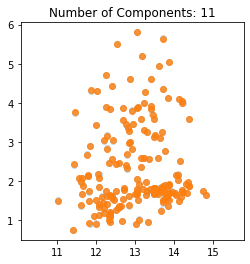

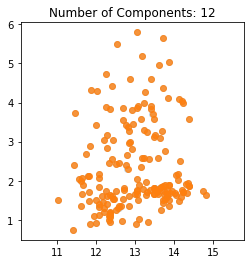

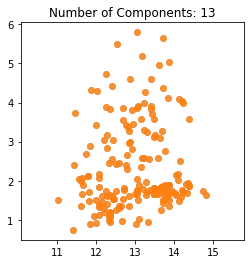

In [65]:
for i in range(1,14):
    ax = plot_pca(X, i)

In [ ]:
def create_pipe(clf, do_pca=False):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Scale all Features
    scaler = StandardScaler()
    
    # This dataset is way too high-dimensional. Better do PCA:
    pca = PCA(n_components=2)

    # Build estimator from PCA and Univariate selection:
    if do_pca == True:
        combined_features = FeatureUnion([("scaler", scaler), ("pca", pca)])
    else:
        combined_features = FeatureUnion([("scaler", scaler)])
    
    pipeline = Pipeline([("features", combined_features), ("clf", clf)])

     
    return pipeline

In [ ]:
models = {'KNeighbors' : KNeighborsClassifier(),
          'RandomForest' : RandomForestClassifier(random_state=42),
          'LogisticReg' : LogisticRegression(multi_class='multinomial', random_state=42)}


for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = KFold(n_splits=10, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))
    print(scores.)

In [ ]:
name = 'KNeighbors'
clf = KNeighborsClassifier()
pipeline = create_pipe(clf)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
clf = KNeighborsClassifier()
pipeline = create_pipe(clf, do_pca=True)

param_grid = dict(features__pca__n_components=[1, 2, 3, 4])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

In [ ]:
# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 clause




# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features were good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)
print("Combined space has", X_features.shape[1], "features")

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)